In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import Counter
from itertools import chain
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


/home/trnmah/mambaforge/envs/practic1/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("NlpHUST/vi-word-segmentation")
model = AutoModelForTokenClassification.from_pretrained("NlpHUST/vi-word-segmentation")

nlp = pipeline("token-classification", model=model, tokenizer=tokenizer, device='cuda')
example = "Phát biểu tại phiên thảo luận về tình hình kinh tế xã hội của Quốc hội sáng 28/10 , Bộ trưởng Bộ LĐ-TB&XH Đào Ngọc Dung khái quát , tại phiên khai mạc kỳ họp , lãnh đạo chính phủ đã báo cáo , đề cập tương đối rõ ràng về việc thực hiện các chính sách an sinh xã hội"

2024-07-16 17:48:07.658928: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-16 17:48:08.760553: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/trnmah/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
vi = pd.read_csv('../../ALT-Parallel-Corpus-20191206Lao/ALT-Parallel-Corpus-20191206/data_vi.txt', sep='\t', header=None)
vi_sentences = vi[1].values.tolist()


In [4]:
def segment_vietnamese_text(sentences: list):
	corpus = []
	for sentence in sentences:
		ner_results = nlp(sentence)
		example_tok = ""
		for e in ner_results:
			if "##" in e["word"]:
				example_tok = example_tok + e["word"].replace("##","")
			elif e["entity"] =="I":
				example_tok = example_tok + "_" + e["word"]
			else:
				example_tok = example_tok + " " + e["word"]
		corpus.append(example_tok)

	return corpus 

In [5]:
corpus = segment_vietnamese_text(vi_sentences[:5000])


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [6]:
# Tokenize the corpus
words = [word.lower() for sentence in corpus for word in sentence.split()]
vocab = set(words)
vocab_size = len(vocab)

# Build word-to-index and index-to-word mappings
word_to_idx = {word: i for i, word in enumerate(vocab)}
idx_to_word = {i: word for word, i in word_to_idx.items()}

# Hyperparameters
context_size = 2  # Number of context words on each side of the target word
embedding_dim = 100 # Dimension of word embeddings

In [7]:
# Prepare data for Skip-gram
def get_context_target_pairs(corpus, context_size):
    pairs = []
    for sentence in corpus:
        words = sentence.lower().split()
        for i in range(len(words)):
            target = words[i]
            context = [words[i + j] for j in range(-context_size, context_size + 1) if j != 0 & 0 <= i + j < len(words)]
            for context_word in context:
                pairs.append((target, context_word))
    return pairs

# Convert words to indices
def words_to_indices(word_list):
    return [word_to_idx[word] for word in word_list]



Target-Context pairs: [('ý', 'đã'), ('ý', 'đánh_bại'), ('đã', 'ý'), ('đã', 'đánh_bại'), ('đã', 'bồ_đào_nha'), ('đánh_bại', 'ý'), ('đánh_bại', 'đã'), ('đánh_bại', 'bồ_đào_nha'), ('đánh_bại', 'với'), ('bồ_đào_nha', 'đã'), ('bồ_đào_nha', 'đánh_bại'), ('bồ_đào_nha', 'với'), ('bồ_đào_nha', 'tỉ_số'), ('với', 'đánh_bại'), ('với', 'bồ_đào_nha'), ('với', 'tỉ_số'), ('với', '31'), ('tỉ_số', 'bồ_đào_nha'), ('tỉ_số', 'với'), ('tỉ_số', '31'), ('tỉ_số', '-'), ('31', 'với'), ('31', 'tỉ_số'), ('31', '-'), ('31', '5'), ('-', 'tỉ_số'), ('-', '31'), ('-', '5'), ('-', 'ở'), ('5', '31'), ('5', '-'), ('5', 'ở'), ('5', 'bảng'), ('ở', '-'), ('ở', '5'), ('ở', 'bảng'), ('ở', 'c'), ('bảng', '5'), ('bảng', 'ở'), ('bảng', 'c'), ('bảng', 'giải_vô_địch'), ('c', 'ở'), ('c', 'bảng'), ('c', 'giải_vô_địch'), ('c', 'rugby'), ('giải_vô_địch', 'bảng'), ('giải_vô_địch', 'c'), ('giải_vô_địch', 'rugby'), ('giải_vô_địch', 'thế_giới'), ('rugby', 'c'), ('rugby', 'giải_vô_địch'), ('rugby', 'thế_giới'), ('rugby', '2007'), ('thế_giớ

In [12]:
# Example of context and target pairs
pairs = get_context_target_pairs(corpus, context_size)
print("Target-Context pairs:", pairs[:4])

Target-Context pairs: [('ý', 'đã'), ('ý', 'đánh_bại'), ('đã', 'ý'), ('đã', 'đánh_bại')]


In [25]:
# Convert context-target pairs to indices
data = [(word_to_idx[target], word_to_idx[context]) for target, context in pairs]

print( "Data:", data[:3])

Data: [(6513, 770), (6513, 8968), (770, 6513)]


In [26]:
from torch.utils.data import DataLoader, Dataset

# i want to from the data list contain tuples of context and target to a Dataloader in Pytorch
class MyDataset(Dataset):
	def __init__(self, data):
		self.data = data
		
	def __len__(self):
		return len(self.data)
	
	def __getitem__(self, idx):
		context, target = self.data[idx]
		return torch.tensor(context), torch.tensor(target)
	
# Create an instance of the dataset
dataset = MyDataset(data)

# Create a dataloader
batch_size = 32 
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

In [15]:
for batch in dataloader:
	context, target = batch 
	print("Context:", context.shape)
	print("Target:", target.shape)
	break

Context: torch.Size([32])
Target: torch.Size([32])


In [16]:
# Define the Skip-gram model
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, vocab_size)
    
    def forward(self, target_word):
        embeds = self.embeddings(target_word)
        out = self.linear1(embeds)
        return out


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
# Initialize the model, loss function, and optimizer
model = SkipGramModel(vocab_size, embedding_dim).to(device)
model = torch.compile(model)
loss_function = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

In [22]:
def train(model, loss_function, optimizer, data_loader, epochs, device):
	# Training the model
	for epoch in range(epochs):
		total_loss = 0
		for context, target in data_loader:
			context = context.to(device)
			target = target.to(device)
			
			model.zero_grad(set_to_none=True)
			log_probs = model(context)
			
			loss = loss_function(log_probs, target)
			loss.backward()
			optimizer.step()
			
			total_loss += loss.item()
		if (epoch + 1) % 10 == 0:
			print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}")



In [23]:
epochs = 5


In [27]:
train(model, loss_function, optimizer, dataloader, epochs, device)

/home/trnmah/mambaforge/envs/practic1/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:124: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


/home/trnmah/mambaforge/envs/practic1/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/trnmah/mambaforge/envs/practic1/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


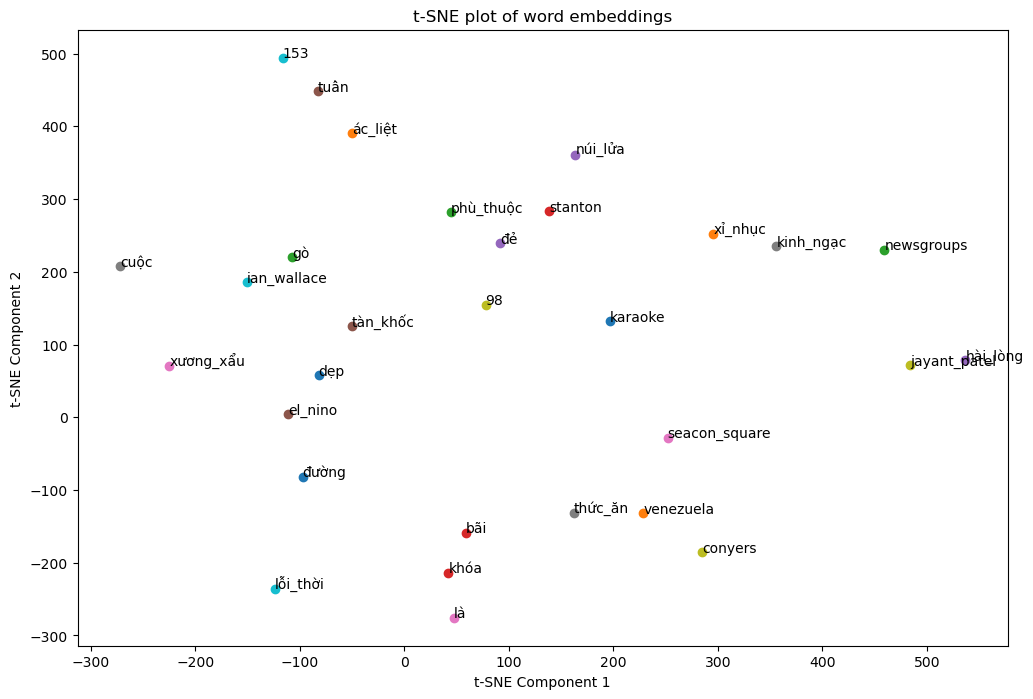

In [31]:
vocab = list(word_to_idx.keys())[:30]
model.eval()
model.to('cpu')
embeddings = model.embeddings.weight.data.numpy()[:30]

# Apply t-SNE to reduce dimensions
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the results
plt.figure(figsize=(12, 8))
for i, word in enumerate(vocab):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1])
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]))

plt.title("t-SNE plot of word embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()